### This notebook draft the figures used in my thesis


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statistics

## Pythia checkpoints

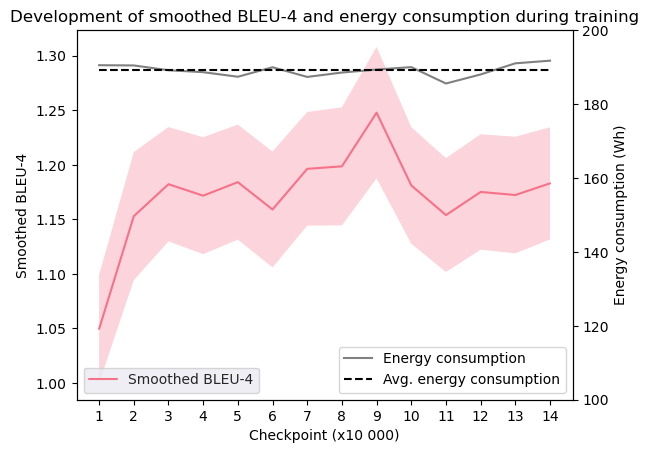

In [4]:
# data obtained from Snellius
smoothed_blue = [1.0495, 1.1529, 1.1822, 1.1717, 1.1841, 1.159, 1.1963, 1.1986, 1.2478, 1.1811, 1.1539, 1.1751, 1.1723, 1.183]
smoothed_blue_stderr = [0.0495, 0.0587, 0.0524, 0.0536, 0.0527, 0.0531, 0.0521, 0.0541, 0.0603, 0.0534, 0.0522, 0.0529, 0.0535, 0.0514]

# obtain energy measurements
df = pd.read_csv("energy_pythia.csv")
pythia_energy = df['total'].tolist()
pythia_energy_avg = statistics.mean(pythia_energy)
pythia_energy_avg = [pythia_energy_avg] * len(pythia_energy)


fig, ax1 = plt.subplots()
clrs = sns.color_palette("husl", 1)


with sns.axes_style("darkgrid"):
    epochs = list(range(len(smoothed_blue)))

    # Plotting the smoothed BLEU data
    meanst = np.array(smoothed_blue, dtype=np.float64)
    sdt = np.array(smoothed_blue_stderr, dtype=np.float64)
    ax1.plot(epochs, meanst, label="Smoothed BLEU-4", c=clrs[0])
    ax1.fill_between(epochs, meanst - sdt, meanst + sdt, alpha=0.3, facecolor=clrs[0])
    
    # set training checkpoints on x-axis
    plt.xticks(np.arange(len(smoothed_blue)), np.arange(1, len(smoothed_blue)+1))  

    # Adding titles and labels
    ax1.set_title('Development of smoothed BLEU-4 and energy consumption during training')
    ax1.set_xlabel('Checkpoint (x10 000)')
    ax1.set_ylabel('Smoothed BLEU-4')
    
    # Add legend
    ax1.legend(loc='lower left')

# Create a second y-axis to the right
ax2 = ax1.twinx()
ax2.plot(epochs, pythia_energy, label="Energy consumption", color='grey')
ax2.plot(epochs, pythia_energy_avg, label="Avg. energy consumption", color='black', linestyle='--')
ax2.set_ylabel('Energy consumption (Wh)')
ax2.set_ylim(0, 200)
ax2.legend(loc='lower right')

# Show plot
plt.show()

#### FORMER PLOT WITH ONLY THE BLUE SCORE #####
# fig, ax = plt.subplots()

# clrs = sns.color_palette("husl", 1)

# with sns.axes_style("darkgrid"):
#     epochs = list(range(len(smoothed_blue)))

#     # Plotting the data
#     meanst = np.array(smoothed_blue, dtype=np.float64)
#     sdt = np.array(smoothed_blue_stderr, dtype=np.float64)
#     ax.plot(epochs, meanst, label="Smoothed BLEU-4", c=clrs[0])
#     ax.fill_between(epochs, meanst - sdt, meanst + sdt, alpha=0.3, facecolor=clrs[0])
    
#     # Add legend
#     ax.legend()

#     # set training checkpoints on x-axis
#     x = list(range(1, len(smoothed_blue)+1))
#     plt.xticks(np.arange(len(smoothed_blue)), np.arange(1, len(smoothed_blue)+1))  

# # Adding titles and labels
# plt.title('Development of smoothed BLEU-4 during training')
# plt.xlabel('Checkpoint (x1000)')
# plt.ylabel('Smoothed BLEU-4')

# # Show plot
# plt.show()

## Quantisation on the StarCoder2 models

In [3]:
tokens = [128, 256]
quantisations = ['', '_4bit', '_8bit']
models = ['3b', '7b']

# Dictionaries to store results
averages_dict = {}
ci_dict = {}

for model in models:
    for token in tokens:
        for quantisation in quantisations:
            # Step 1: Read the CSV file
            file_path = f'energy_data_3/results_{model}_{token}{quantisation}.csv'
            data = pd.read_csv(file_path)

            # Step 2: Compute the average and standard deviation for each column
            averages = data.mean()
            standard_deviations = data.std()
            lower_ci = averages - 1.96 * standard_deviations
            upper_ci = averages + 1.96 * standard_deviations

            # Store the results
            config_key = f'{model}_{token}{quantisation}'
            averages_dict[config_key] = averages.round(2)
            ci_dict[config_key] = {
                'lower': lower_ci.round(2),
                'upper': upper_ci.round(2)
            }

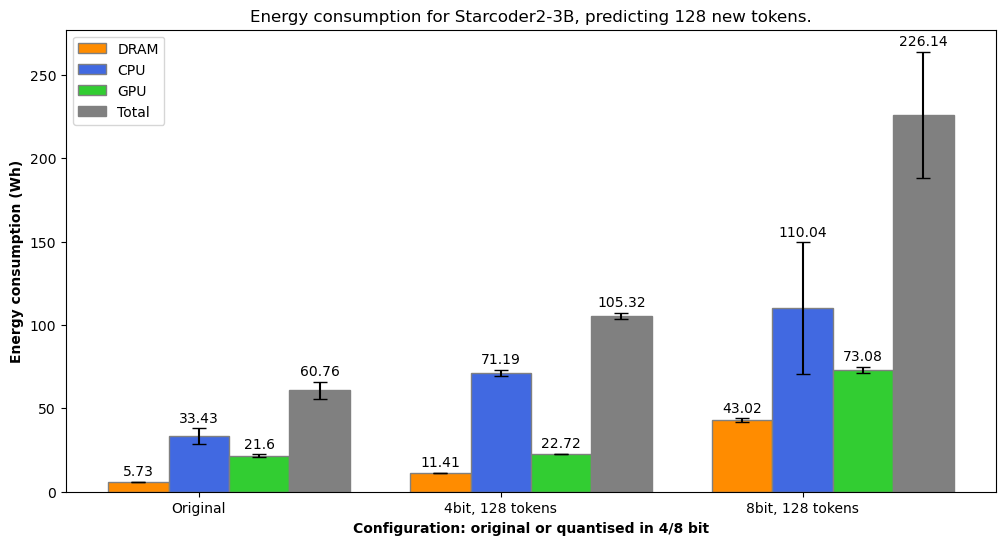

In [4]:
# Data
configurations = ['Original', '4bit, 128 tokens', '8bit, 128 tokens']

def extract_values(component):
    values = []
    ci_lower = []
    ci_upper = []

    for config in configurations:
        model = '3b'
        if config == 'Original':
            quantisation = ''
            token = 128
        else:
            quantisation, token_str = config.split(', ')
            token = int(token_str.split()[0])
            quantisation = '_' + quantisation.lower()

        key = f'{model}_{token}{quantisation}'
        values.append(averages_dict[key][component])
        ci_lower.append(ci_dict[key]['lower'][component])
        ci_upper.append(ci_dict[key]['upper'][component])

    return values, list(zip(ci_lower, ci_upper))

# Extract values for each component
dram, ci_dram = extract_values('DRAM')
cpu, ci_cpu = extract_values('CPU')
gpu, ci_gpu = extract_values('GPU')
total, ci_total = extract_values('total')

# Calculate error margins
def calculate_errors(data, ci):
    return [[data[i] - ci[i][0] for i in range(len(data))],
            [ci[i][1] - data[i] for i in range(len(data))]]

dram_errors = calculate_errors(dram, ci_dram)
cpu_errors = calculate_errors(cpu, ci_cpu)
gpu_errors = calculate_errors(gpu, ci_gpu)
total_errors = calculate_errors(total, ci_total)

# Number of bars per group
n_bars = len(configurations)

# Set the bar width
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(n_bars)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create the plot
plt.figure(figsize=(12, 6))

# Create bars with standard deviation whiskers
bar_dram = plt.bar(r1, dram, color='darkorange', width=bar_width, edgecolor='grey', label='DRAM', yerr=dram_errors, capsize=5)
bar_cpu = plt.bar(r2, cpu, color='royalblue', width=bar_width, edgecolor='grey', label='CPU', yerr=cpu_errors, capsize=5)
bar_gpu = plt.bar(r3, gpu, color='limegreen', width=bar_width, edgecolor='grey', label='GPU', yerr=gpu_errors, capsize=5)
bar_tot = plt.bar(r4, total, color='gray', width=bar_width, edgecolor='grey', label='Total', yerr=total_errors, capsize=5)

# for different colours: https://matplotlib.org/stable/gallery/color/named_colors.html

# Add labels
plt.xlabel('Configuration: original or quantised in 4/8 bit', fontweight='bold')
plt.ylabel('Energy consumption (Wh)', fontweight='bold')
plt.xticks([r + bar_width for r in range(n_bars)], configurations)

# Add legend
plt.legend()
barlist = [bar_dram, bar_cpu, bar_gpu, bar_tot]
ci_list = [ci_dram, ci_cpu, ci_gpu, ci_total]

# Display average above bar
for sub_bar, ci in zip(barlist, ci_list):
    for bar, (ci_lower, ci_upper) in zip(sub_bar, ci):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, ci_upper + 2, round(yval, 2), ha='center', va='bottom') 

# Display the plot
plt.title('Energy consumption for Starcoder2-3B, predicting 128 new tokens.')
# plt.show()
plt.savefig("Energy_3b_128.png")

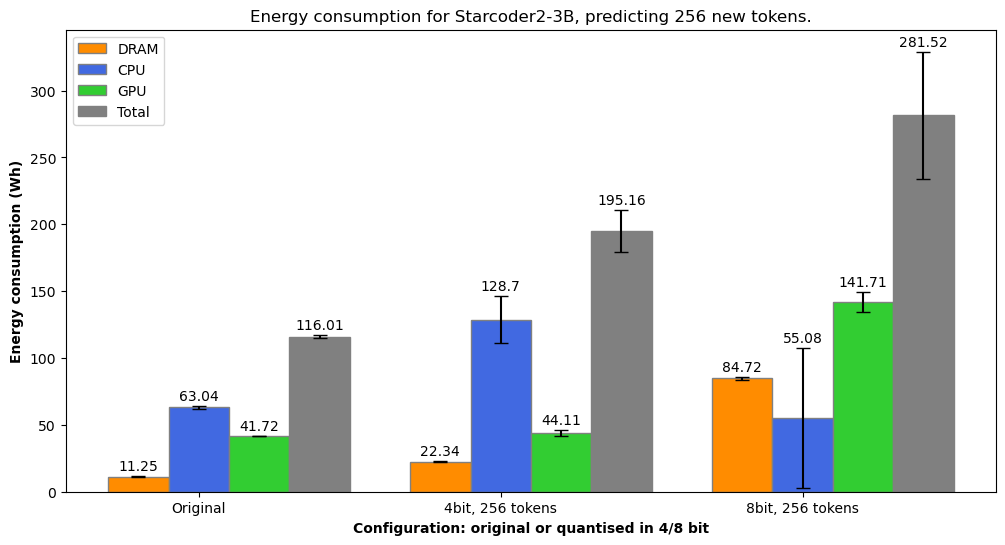

In [5]:
# Data
configurations = ['Original', '4bit, 256 tokens', '8bit, 256 tokens']

def extract_values(component):
    values = []
    ci_lower = []
    ci_upper = []

    for config in configurations:
        model = '3b'
        if config == 'Original':
            quantisation = ''
            token = 256
        else:
            quantisation, token_str = config.split(', ')
            token = int(token_str.split()[0])
            quantisation = '_' + quantisation.lower()

        key = f'{model}_{token}{quantisation}'
        values.append(averages_dict[key][component])
        ci_lower.append(ci_dict[key]['lower'][component])
        ci_upper.append(ci_dict[key]['upper'][component])

    return values, list(zip(ci_lower, ci_upper))

# Extract values for each component
dram, ci_dram = extract_values('DRAM')
cpu, ci_cpu = extract_values('CPU')
gpu, ci_gpu = extract_values('GPU')
total, ci_total = extract_values('total')

# Calculate error margins
def calculate_errors(data, ci):
    return [[data[i] - ci[i][0] for i in range(len(data))],
            [ci[i][1] - data[i] for i in range(len(data))]]

dram_errors = calculate_errors(dram, ci_dram)
cpu_errors = calculate_errors(cpu, ci_cpu)
gpu_errors = calculate_errors(gpu, ci_gpu)
total_errors = calculate_errors(total, ci_total)

# Number of bars per group
n_bars = len(configurations)

# Set the bar width
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(n_bars)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create the plot
plt.figure(figsize=(12, 6))

# Create bars with standard deviation whiskers
bar_dram = plt.bar(r1, dram, color='darkorange', width=bar_width, edgecolor='grey', label='DRAM', yerr=dram_errors, capsize=5)
bar_cpu = plt.bar(r2, cpu, color='royalblue', width=bar_width, edgecolor='grey', label='CPU', yerr=cpu_errors, capsize=5)
bar_gpu = plt.bar(r3, gpu, color='limegreen', width=bar_width, edgecolor='grey', label='GPU', yerr=gpu_errors, capsize=5)
bar_tot = plt.bar(r4, total, color='gray', width=bar_width, edgecolor='grey', label='Total', yerr=total_errors, capsize=5)

# for different colours: https://matplotlib.org/stable/gallery/color/named_colors.html

# Add labels
plt.xlabel('Configuration: original or quantised in 4/8 bit', fontweight='bold')
plt.ylabel('Energy consumption (Wh)', fontweight='bold')
plt.xticks([r + bar_width for r in range(n_bars)], configurations)

# Add legend
plt.legend()
barlist = [bar_dram, bar_cpu, bar_gpu, bar_tot]
ci_list = [ci_dram, ci_cpu, ci_gpu, ci_total]

for sub_bar, ci in zip(barlist, ci_list):
    for bar, (ci_lower, ci_upper) in zip(sub_bar, ci):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, ci_upper + 2, round(yval, 2), ha='center', va='bottom')  # Offset above the upper CI

# Display the plot
plt.title('Energy consumption for Starcoder2-3B, predicting 256 new tokens.')
# plt.show()
plt.savefig("Energy_3b_256.png")

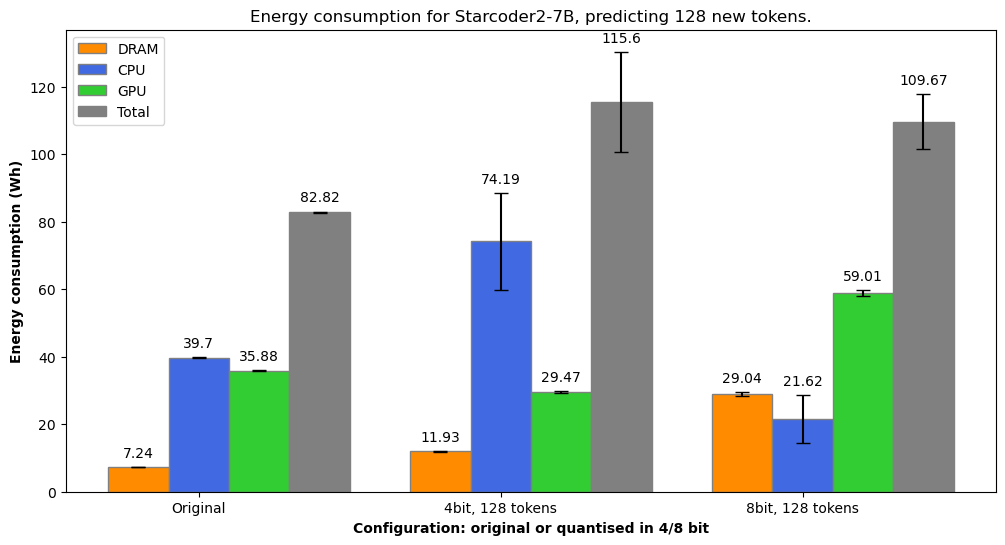

In [6]:
# Data
configurations = ['Original', '4bit, 128 tokens', '8bit, 128 tokens']

def extract_values(component):
    values = []
    ci_lower = []
    ci_upper = []

    for config in configurations:
        model = '7b'
        if config == 'Original':
            quantisation = ''
            token = 128
        else:
            quantisation, token_str = config.split(', ')
            token = int(token_str.split()[0])
            quantisation = '_' + quantisation.lower()

        key = f'{model}_{token}{quantisation}'
        values.append(averages_dict[key][component])
        ci_lower.append(ci_dict[key]['lower'][component])
        ci_upper.append(ci_dict[key]['upper'][component])

    return values, list(zip(ci_lower, ci_upper))

# Extract values for each component
dram, ci_dram = extract_values('DRAM')
cpu, ci_cpu = extract_values('CPU')
gpu, ci_gpu = extract_values('GPU')
total, ci_total = extract_values('total')

# Calculate error margins
def calculate_errors(data, ci):
    return [[data[i] - ci[i][0] for i in range(len(data))],
            [ci[i][1] - data[i] for i in range(len(data))]]

dram_errors = calculate_errors(dram, ci_dram)
cpu_errors = calculate_errors(cpu, ci_cpu)
gpu_errors = calculate_errors(gpu, ci_gpu)
total_errors = calculate_errors(total, ci_total)

# Number of bars per group
n_bars = len(configurations)

# Set the bar width
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(n_bars)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create the plot
plt.figure(figsize=(12, 6))

# Create bars with standard deviation whiskers
bar_dram = plt.bar(r1, dram, color='darkorange', width=bar_width, edgecolor='grey', label='DRAM', yerr=dram_errors, capsize=5)
bar_cpu = plt.bar(r2, cpu, color='royalblue', width=bar_width, edgecolor='grey', label='CPU', yerr=cpu_errors, capsize=5)
bar_gpu = plt.bar(r3, gpu, color='limegreen', width=bar_width, edgecolor='grey', label='GPU', yerr=gpu_errors, capsize=5)
bar_tot = plt.bar(r4, total, color='gray', width=bar_width, edgecolor='grey', label='Total', yerr=total_errors, capsize=5)


# for different colours: https://matplotlib.org/stable/gallery/color/named_colors.html

# Add labels
plt.xlabel('Configuration: original or quantised in 4/8 bit', fontweight='bold')
plt.ylabel('Energy consumption (Wh)', fontweight='bold')
plt.xticks([r + bar_width for r in range(n_bars)], configurations)

# Add legend
plt.legend()
barlist = [bar_dram, bar_cpu, bar_gpu, bar_tot]
ci_list = [ci_dram, ci_cpu, ci_gpu, ci_total]

for sub_bar, ci in zip(barlist, ci_list):
    for bar, (ci_lower, ci_upper) in zip(sub_bar, ci):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, ci_upper + 2, round(yval, 2), ha='center', va='bottom')  # Offset above the upper CI

# Display the plot
plt.title('Energy consumption for Starcoder2-7B, predicting 128 new tokens.')
# plt.show()
plt.savefig("Energy_7b_128.png")

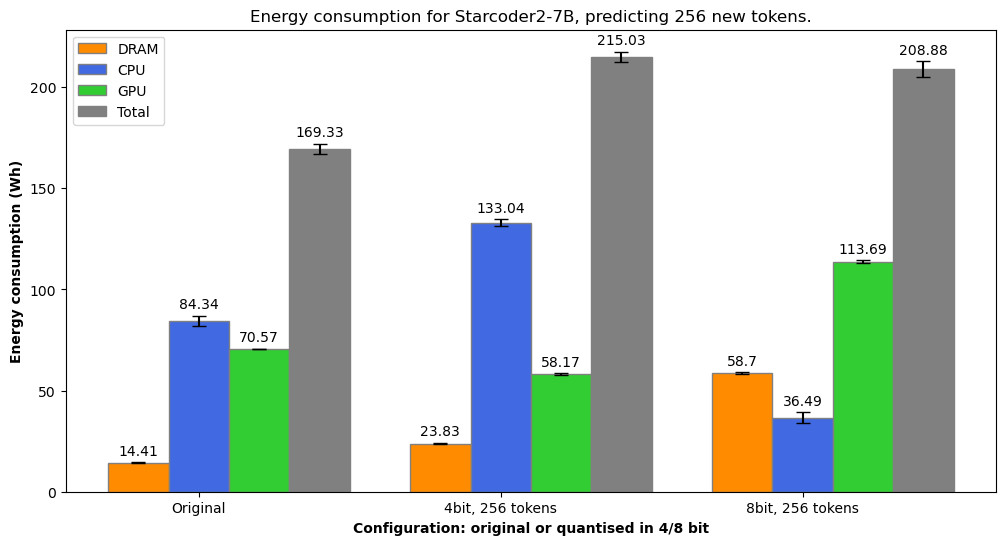

In [7]:
# Data
configurations = ['Original', '4bit, 256 tokens', '8bit, 256 tokens']

def extract_values(component):
    values = []
    ci_lower = []
    ci_upper = []

    for config in configurations:
        model = '7b'
        if config == 'Original':
            quantisation = ''
            token = 256
        else:
            quantisation, token_str = config.split(', ')
            token = int(token_str.split()[0])
            quantisation = '_' + quantisation.lower()

        key = f'{model}_{token}{quantisation}'
        values.append(averages_dict[key][component])
        ci_lower.append(ci_dict[key]['lower'][component])
        ci_upper.append(ci_dict[key]['upper'][component])

    return values, list(zip(ci_lower, ci_upper))

# Extract values for each component
dram, ci_dram = extract_values('DRAM')
cpu, ci_cpu = extract_values('CPU')
gpu, ci_gpu = extract_values('GPU')
total, ci_total = extract_values('total')

# Calculate error margins
def calculate_errors(data, ci):
    return [[data[i] - ci[i][0] for i in range(len(data))],
            [ci[i][1] - data[i] for i in range(len(data))]]

dram_errors = calculate_errors(dram, ci_dram)
cpu_errors = calculate_errors(cpu, ci_cpu)
gpu_errors = calculate_errors(gpu, ci_gpu)
total_errors = calculate_errors(total, ci_total)

# Number of bars per group
n_bars = len(configurations)

# Set the bar width
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(n_bars)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create the plot
plt.figure(figsize=(12, 6))

# Create bars with standard deviation whiskers
bar_dram = plt.bar(r1, dram, color='darkorange', width=bar_width, edgecolor='grey', label='DRAM', yerr=dram_errors, capsize=5)
bar_cpu = plt.bar(r2, cpu, color='royalblue', width=bar_width, edgecolor='grey', label='CPU', yerr=cpu_errors, capsize=5)
bar_gpu = plt.bar(r3, gpu, color='limegreen', width=bar_width, edgecolor='grey', label='GPU', yerr=gpu_errors, capsize=5)
bar_tot = plt.bar(r4, total, color='gray', width=bar_width, edgecolor='grey', label='Total', yerr=total_errors, capsize=5)


# for different colours: https://matplotlib.org/stable/gallery/color/named_colors.html

# Add labels
plt.xlabel('Configuration: original or quantised in 4/8 bit', fontweight='bold')
plt.ylabel('Energy consumption (Wh)', fontweight='bold')
plt.xticks([r + bar_width for r in range(n_bars)], configurations)

# Add legend
plt.legend()
barlist = [bar_dram, bar_cpu, bar_gpu, bar_tot]
ci_list = [ci_dram, ci_cpu, ci_gpu, ci_total]

for sub_bar, ci in zip(barlist, ci_list):
    for bar, (ci_lower, ci_upper) in zip(sub_bar, ci):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, ci_upper + 2, round(yval, 2), ha='center', va='bottom')  # Offset above the upper CI

# Display the plot
plt.title('Energy consumption for Starcoder2-7B, predicting 256 new tokens.')
# plt.show()
plt.savefig("Energy_7b_256.png")

## Time measurements

In [8]:
for model in models:
    for token in tokens:
        for quantisation in quantisations:
            print(f"\nModel {model}, {token} tokens & quantisation {quantisation}:")
            file_path = f'energy_data_3/results_{model}_{token}{quantisation}.csv'
            data = pd.read_csv(file_path)

            # Step 2: Compute the average and standard deviation for each column
            averages = data.mean()
            standard_deviations = data.std()

            print(f"Average: {round(averages['Runtime'], 1)}, std. {round(standard_deviations['Runtime'],1)}.")
            print(f"Throughput: {round((token*164)/round(averages['Runtime'], 1),1)} tokens per second")


Model 3b, 128 tokens & quantisation :
Average: 458.3, std. 3.6.
Throughput: 45.8 tokens per second

Model 3b, 128 tokens & quantisation _4bit:
Average: 912.9, std. 2.7.
Throughput: 23.0 tokens per second

Model 3b, 128 tokens & quantisation _8bit:
Average: 3441.2, std. 40.1.
Throughput: 6.1 tokens per second

Model 3b, 256 tokens & quantisation :
Average: 900.0, std. 6.9.
Throughput: 46.6 tokens per second

Model 3b, 256 tokens & quantisation _4bit:
Average: 1787.3, std. 15.9.
Throughput: 23.5 tokens per second

Model 3b, 256 tokens & quantisation _8bit:
Average: 6777.7, std. 56.3.
Throughput: 6.2 tokens per second

Model 7b, 128 tokens & quantisation :
Average: 579.3, std. 1.0.
Throughput: 36.2 tokens per second

Model 7b, 128 tokens & quantisation _4bit:
Average: 954.4, std. 8.2.
Throughput: 22.0 tokens per second

Model 7b, 128 tokens & quantisation _8bit:
Average: 2323.3, std. 21.6.
Throughput: 9.0 tokens per second

Model 7b, 256 tokens & quantisation :
Average: 1152.9, std. 2.2.

### Accuracy for pruning

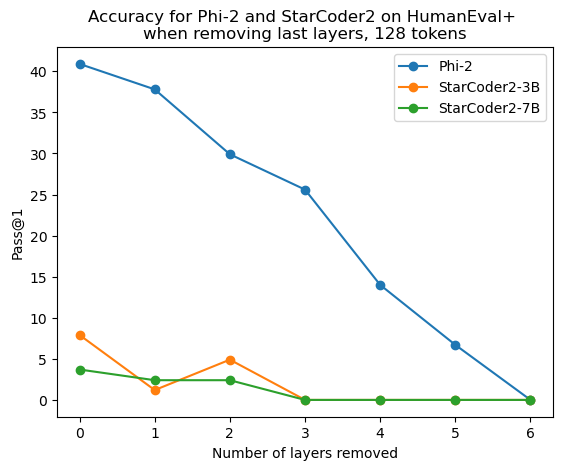

In [4]:
# add results from job ID 6463852

accs_evalplus_phi = [0.409, 0.378, 0.299, 0.256, 0.140, 0.067, 0]
accs_evalplus_3b = [0.079, 0.012, 0.049, 0, 0, 0, 0]
accs_evalplus_7b = [0.037, 0.024, 0.024, 0, 0, 0, 0]

# match tables
accs_evalplus_phi = [x * 100 for x in accs_evalplus_phi]
accs_evalplus_3b = [x * 100 for x in accs_evalplus_3b]
accs_evalplus_7b = [x * 100 for x in accs_evalplus_7b]

# Indices (assuming these are the x-values)
x = list(range(0, len(accs_evalplus_phi)))

# Plotting the data
plt.plot(x, accs_evalplus_phi, marker='o', label='Phi-2')
plt.plot(x, accs_evalplus_3b, marker='o', label='StarCoder2-3B')
plt.plot(x, accs_evalplus_7b, marker='o', label='StarCoder2-7B')

# Adding titles and labels
plt.title('Accuracy for Phi-2 and StarCoder2 on HumanEval+ \nwhen removing last layers, 128 tokens')
plt.xlabel('Number of layers removed')
plt.ylabel('Pass@1')

plt.xticks(x)

# Adding a legend
plt.legend()

# Showing the plot

# plt.show()
plt.savefig("exp3_pruning.png")

### Energy consumption for pruning


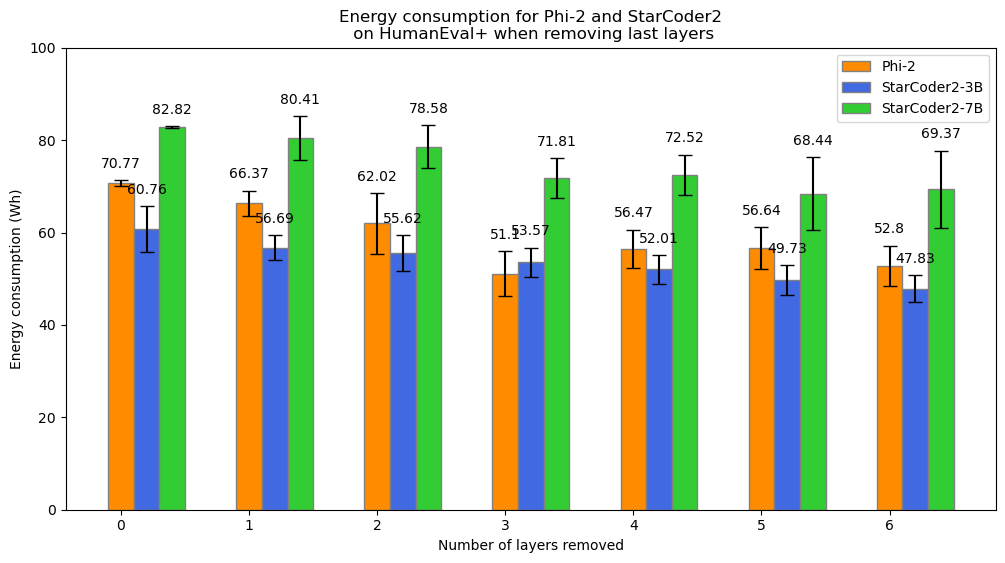

In [10]:
models = ['Phi2','3b', '7b']
layers = [1,2,3,4,5,6]

# list energy measurements
phi2_total = []
star3b_total = []
star7b_total = []

phi2_err = []
star3b_err = []
star7b_err = []
            
# add data
for model in models:
    for layer in layers:
#         print(f"\nModel {model}, 128 tokens & {layer} layers removed :")
        file_path = f'pruning/{model}_128_minus_{layer}.csv'
        data = pd.read_csv(file_path)

        # Step 2: Compute the average and standard deviation for each column
        averages = data.mean()
        standard_deviations = data.std()

#         print(f"Average: {round(averages['Runtime'], 1)}, std. {round(standard_deviations['Runtime'],1)}.")
#         print(f"Throughput: {round((128*164)/round(averages['Runtime'], 1),1)} tokens per second")
        
        if model == 'Phi2':
            phi2_total.append(averages['total'])
            lower_ci = averages['total'] - 1.96 * standard_deviations['total']
            upper_ci = averages['total'] + 1.96 * standard_deviations['total']
            phi2_err.append([lower_ci, upper_ci])
            
        elif model == '3b':
            star3b_total.append(averages['total'])
            lower_ci = averages['total'] - 1.96 * standard_deviations['total']
            upper_ci = averages['total'] + 1.96 * standard_deviations['total']
            star3b_err.append([lower_ci, upper_ci])
        
        elif model == '7b':
            star7b_total.append(averages['total'])
            lower_ci = averages['total'] - 1.96 * standard_deviations['total']
            upper_ci = averages['total'] + 1.96 * standard_deviations['total']
            star7b_err.append([lower_ci, upper_ci])
            
# insert values from original models (cell 4 & 6)

file_path = f'energy_data_3/results_Phi2_128.csv'
data = pd.read_csv(file_path)
averages = data['total'].mean()
standard_deviations = data['total'].std()

phi2_total.insert(0, averages)
phi2_err.insert(0, [averages-1.96*standard_deviations, averages+1.96*standard_deviations])

file_path = f'energy_data_3/results_3b_128.csv'
data = pd.read_csv(file_path)
averages = data['total'].mean()
standard_deviations = data['total'].std()

star3b_total.insert(0, averages)
star3b_err.insert(0, [averages-1.96*standard_deviations, averages+1.96*standard_deviations])

file_path = f'energy_data_3/results_7b_128.csv'
data = pd.read_csv(file_path)
averages = data['total'].mean()
standard_deviations = data['total'].std()

star7b_total.insert(0, averages)
star7b_err.insert(0, [averages-1.96*standard_deviations, averages+1.96*standard_deviations])

# Calculate error margins
def calculate_errors(data, ci):
    return [[data[i] - ci[i][0] for i in range(len(data))],
            [ci[i][1] - data[i] for i in range(len(data))]]

phi2_errors = calculate_errors(phi2_total, phi2_err)
star3b_errors = calculate_errors(star3b_total, star3b_err)
star7b_errors = calculate_errors(star7b_total, star7b_err)

# Number of bars per group
n_bars = len(phi2_total)

# Set the bar width
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(n_bars)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the plot
plt.figure(figsize=(12, 6))

# Create bars with standard deviation whiskers
bar_phi = plt.bar(r1, phi2_total, color='darkorange', width=bar_width, edgecolor='grey', label='Phi-2', yerr=phi2_errors, capsize=5)
bar_3b = plt.bar(r2, star3b_total, color='royalblue', width=bar_width, edgecolor='grey', label='StarCoder2-3B', yerr=star3b_errors, capsize=5)
bar_7b = plt.bar(r3, star7b_total, color='limegreen', width=bar_width, edgecolor='grey', label='StarCoder2-7B', yerr=star7b_errors, capsize=5)

# Create bars without standard deviation whiskers
# bar_phi = plt.bar(r1, phi2_total, color='darkorange', width=bar_width, edgecolor='grey', label='Phi-2', capsize=5)
# bar_3b = plt.bar(r2, star3b_total, color='royalblue', width=bar_width, edgecolor='grey', label='StarCoder2-3B', capsize=5)
# bar_7b = plt.bar(r3, star7b_total, color='limegreen', width=bar_width, edgecolor='grey', label='StarCoder2-7B', capsize=5)

# for different colours: https://matplotlib.org/stable/gallery/color/named_colors.html

plt.title('Energy consumption for Phi-2 and StarCoder2\n on HumanEval+ when removing last layers')
plt.xlabel('Number of layers removed')
plt.ylabel('Energy consumption (Wh)')

# Indices (assuming these are the x-values)
x = list(range(0, len(accs_evalplus_phi)))
plt.xticks(x)
plt.ylim(0,100)

# Add legend
plt.legend()
barlist = [bar_phi, bar_3b, bar_7b]
ci_list = [phi2_err, star3b_err, star7b_err]

for sub_bar, ci in zip(barlist, ci_list):
    for bar, (ci_lower, ci_upper) in zip(sub_bar, ci):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, ci_upper + 2, round(yval, 2), ha='center', va='bottom')  # Offset above the upper CI

# Display the plot
# plt.show()
plt.savefig("Energy_pruning.png")